### Programming Language - Job Satisfaction Correlation
Year range: 2017 -2020

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from pprint import pprint
import re

In [2]:
import cufflinks as cf
import plotly.offline

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
import re
def camel_to_snake(name):
    # https://stackoverflow.com/a/1176023
    name = name.replace(' ', '_').replace("'", '').replace(':', '_').replace('?','')
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('_+', r'_', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [5]:
def load_datasets(years=[], format_col_names=True, user_selected_cols=True):
    years = years or list(range(2011,2021))
    dataset_base_file_name = 'stack_overflow_datasets/survey_results_'

    dfs = {}
    for year in years:
        name = f'{dataset_base_file_name}{year}.csv'
        df = pd.read_csv(name, dtype=object)

        if format_col_names:
            df.columns = map(lambda name: camel_to_snake(name), df.columns)
        df['year'] = year
        dfs[year] = df

    return dfs

In [6]:
datasets = load_datasets(list(range(2017, 2021)))

In [7]:
cols = ["DeveloperType", "WebDeveloperType", "MobileDeveloperType", "NonDeveloperType"]
cols = map(camel_to_snake, cols)

datasets[2017][cols].head(10)

,developer_type,web_developer_type,mobile_developer_type,non_developer_type
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,Other,NaN,NaN,NaN
3,NaN,NaN,NaN,Data scientist
4,Mobile developer; Graphics programming; Desktop applications developer,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,Data scientist
7,Web developer,Full stack Web developer,NaN,NaN
8,Web developer; Mobile developer,NaN,NaN,NaN
9,Mobile developer; Desktop applications developer,NaN,NaN,NaN


In [8]:
def identify_web_developer_type(developer_type, web_developer_type):
    if (
        not(pd.isnull(developer_type) or pd.isnull(web_developer_type)) 
        and developer_type and web_developer_type
    ):
        return developer_type.replace('Web developer', web_developer_type)
    return developer_type


def merge_dev_and_non_dev_types(developer_type, non_developer_type):
    if pd.isnull(developer_type):
        return non_developer_type
    elif pd.isnull(non_developer_type):
        return developer_type
    else:
        return f"{developer_type};{non_developer_type}"

    
def update_2017_developer_type_values():
    df_2017 = datasets[2017]
    df_2017['developer_type'] = df_2017.apply(
        lambda x: identify_web_developer_type(x['developer_type'], x['web_developer_type']), axis=1
    )
    
    df_2017['dev_type'] = df_2017.apply(
        lambda x: merge_dev_and_non_dev_types(x['developer_type'], x['non_developer_type']), axis=1
    )

In [9]:
update_2017_developer_type_values()

In [10]:
def concat_dev_type_feature():
    cols = ['respondent', 'year', 'dev_type']
    frames = []
    for df in datasets.values():
        frames.append(df[cols])
    
    return pd.concat(frames)

In [11]:
dev_type_df = concat_dev_type_feature()

In [12]:
def explode_feature(df, feature):
    df[feature] = df[feature].str.split(';')
    df_explode = df.explode(feature)
    df_explode[feature] = df_explode[feature].str.strip()
    return df_explode

In [13]:
dev_type_explode = explode_feature(dev_type_df, 'dev_type')

In [14]:
def feature_across_years(df, feature, year_resume=True, value_counts=True, year_and_labels=True):

    df_counts = df[feature].value_counts().to_frame()
    if value_counts:
        display(df_counts)

    feature_df = df.groupby(['year', feature])[feature].count().to_frame()
    feature_df.columns = ['count']
    feature_df['percentage'] = feature_df.groupby(level=0).apply(lambda x: x / float(x.sum())).round(4)
    feature_df = feature_df.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values('count', ascending=False))
    if year_resume:
        display(feature_df)

    if year_and_labels:
        df_year_and_labels = feature_df.reset_index()[['year', feature]]
        display(df_year_and_labels)


In [15]:
feature_across_years(dev_type_explode, 'dev_type', year_resume=True, value_counts=False, year_and_labels=False)

count  percentage
year dev_type                                                                
2017 Web developer                                          15544      0.1851
     Desktop applications developer                         10435      0.1243
     Mobile developer                                        8326      0.0992
     Full stack Web developer                                6816      0.0812
     Database administrator                                  5192      0.0618
     Other                                                   4252      0.0506
     Data scientist                                          4145      0.0494
     Developer with a statistics or mathematics background   4091      0.0487
     Systems administrator                                   4086      0.0487
     DevOps specialist                                       4015      0.0478
     Embedded applications/devices developer                 3352      0.0399
     Back-end Web developer                                  2606      0.0310
     Analyst or consultant                                   1897      0.0226
     Graphics programming                                    1731      0.0206
     Graphic designer                                        1426      0.0170
     Machine learning specialist                             1379      0.0164
     Front-end Web developer                                 1269      0.0151
     Quality assurance engineer                              1252      0.0149
     Educator or academic                                     732      0.0087
     Designer or illustrator                                  600      0.0071
     Product manager                                          365      0.0043
     C-suite executive                                        257      0.0031
     Marketing or sales manager                               152      0.0018
     Elected official                                          34      0.0004
2018 Back-end developer                                     53300      0.1930
     Full-stack developer                                   44353      0.1606
     Front-end developer                                    34822      0.1261
     Mobile developer                                       18804      0.0681
     Desktop or enterprise applications developer           15807      0.0572
     Student                                                15732      0.0570
     Database administrator                                 13216      0.0479
     Designer                                               12019      0.0435
     System administrator                                   10375      0.0376
     DevOps specialist                                       9549      0.0346
     Data or business analyst                                7559      0.0274
     Data scientist or machine learning specialist           7088      0.0257
     QA or test developer                                    6194      0.0224
     Engineering manager                                     5256      0.0190
     Embedded applications or devices developer              4819      0.0175
     Game or graphics developer                              4642      0.0168
     Product manager                                         4316      0.0156
     Educator or academic researcher                         3641      0.0132
     C-suite executive (CEO, CTO, etc.)                      3491      0.0126
     Marketing or sales professional                         1122      0.0041
2019 Developer, full-stack                                  42222      0.1656
     Developer, back-end                                    40665      0.1595
     Developer, front-end                                   26649      0.1046
     Developer, desktop or enterprise applications          17316      0.0679
     Developer, mobile                                      14698      0.0577
     Student                                                11921      0.0468
    

In [16]:
job_satisfaction_2018 = datasets[2018].job_satisfaction.str.get_dummies()
job_satisfaction_2018.head()

,Extremely dissatisfied,Extremely satisfied,Moderately dissatisfied,Moderately satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Slightly satisfied
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1


In [17]:
df_languages_2018 = datasets[2018].language_worked_with.str.split(';').str.join('|').str.get_dummies()
df_languages_2018.head()

,Assembly,Bash/Shell,C,C#,C++,CSS,Clojure,Cobol,CoffeeScript,Delphi/Object Pascal,Erlang,F#,Go,Groovy,HTML,Hack,Haskell,Java,JavaScript,Julia,Kotlin,Lua,Matlab,Objective-C,Ocaml,PHP,Perl,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VB.NET,VBA,Visual Basic 6
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [18]:
language_jobsatisfaction_2018 = pd.concat([df_languages_2018, job_satisfaction_2018], axis=1, join='inner', sort=False)

correlation_df = language_jobsatisfaction_2018.corr()

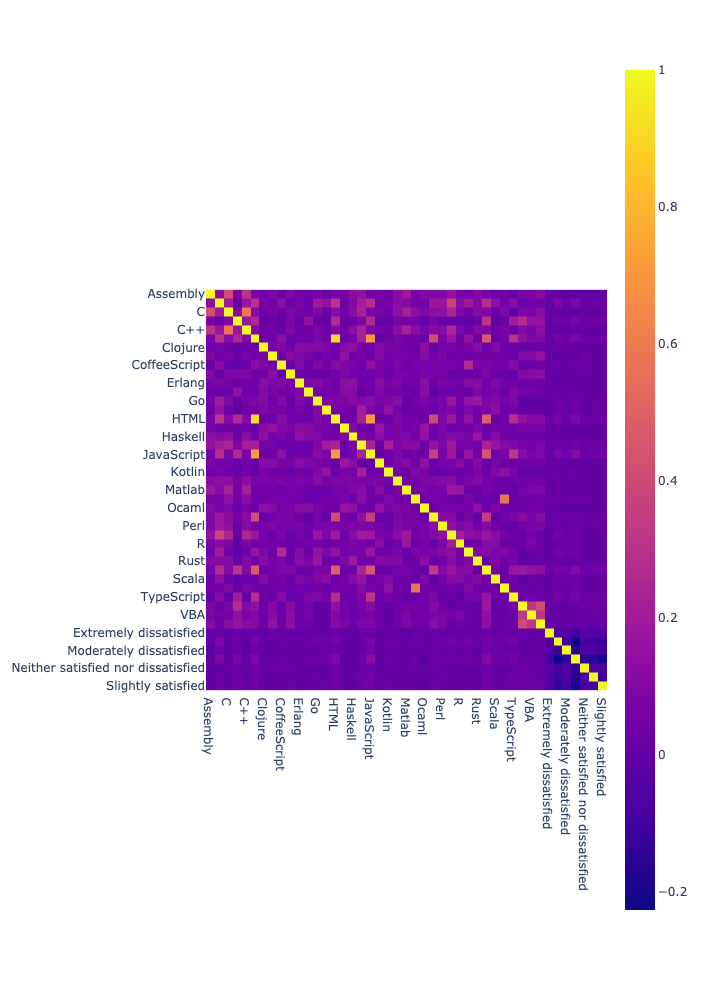

In [19]:
import plotly.express as px

fig = px.imshow(correlation_df)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.show()